This notebook presents an interaction of Diva tools to read data with the [leaflet](http://leafletjs.com/) library using the [folium](http://python-visualization.github.io/folium/) and the [pydiva2D](./pydiva2d.py) modules.

In [1]:
import os
import logging
import pydiva2d
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import subprocess
from importlib import reload
%matplotlib inline

/usr/local/lib/python3.6/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [2]:
reload(pydiva2d)

<module 'pydiva2d' from '/home/ctroupin/Projects/SeaDataCloud/Python/pydiva2d.py'>

In [3]:
logger = logging.getLogger('diva2D')
logger.setLevel(logging.CRITICAL)

# Get the data

The input files are located in the *data* directory.

In [4]:
datadir = './data/'
datafile = os.path.join(datadir, 'MLD1.dat')
coastfile = os.path.join(datadir, 'coast.cont')
paramfile = os.path.join(datadir, 'param.par')

As in the previous example, we create the paths for the Diva directories and files:

In [5]:
divadir = "/home/ctroupin/Software/DIVA/diva-4.7.1"
DivaDirs = pydiva2d.DivaDirectories(divadir)
DivaFiles = pydiva2d.Diva2Dfiles(DivaDirs.diva2d)

Let's read the information from the input files.

In [6]:
reload(pydiva2d)

<module 'pydiva2d' from '/home/ctroupin/Projects/SeaDataCloud/Python/pydiva2d.py'>

In [7]:
Data = pydiva2d.Diva2DData()
Data.read_from(datafile)
Contour = pydiva2d.Diva2DContours()
Contour.read_from(coastfile)
Param = pydiva2d.Diva2DParameters()
Param.read_from(paramfile)

INFO:diva2D:Creating Diva 2D data object
INFO:diva2D:Reading data from file ./data/MLD1.dat
INFO:diva2D:Creating Diva 2D contour object
INFO:diva2D:Reading contours from file ./data/coast.cont
DEBUG:diva2D:Number of contours: 28
INFO:diva2D:Creating Diva 2D parameter object
INFO:diva2D:Reading parameters from file ./data/param.par


# Make the analysis

We write the input to the corresponding files:

In [8]:
Data.write_to(DivaFiles.data)
Param.write_to(DivaFiles.parameter)
Contour.write_to(DivaFiles.contour)

INFO:diva2D:Written data into file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/data.dat
INFO:diva2D:Written parameters into file /home/ctroupin/Software/DIVA/diva-4.7.1/DIVA3D/divastripped/input/param.par
INFO:diva2D:Number of contours: 28
INFO:diva2D:Number of contours: 28
DEBUG:diva2D:Sub-contour no. 1 has 576 points
DEBUG:diva2D:Sub-contour no. 2 has 16 points
DEBUG:diva2D:Sub-contour no. 3 has 16 points
DEBUG:diva2D:Sub-contour no. 4 has 4 points
DEBUG:diva2D:Sub-contour no. 5 has 36 points
DEBUG:diva2D:Sub-contour no. 6 has 12 points
DEBUG:diva2D:Sub-contour no. 7 has 4436 points
DEBUG:diva2D:Sub-contour no. 8 has 10 points
DEBUG:diva2D:Sub-contour no. 9 has 4 points
DEBUG:diva2D:Sub-contour no. 10 has 10 points
DEBUG:diva2D:Sub-contour no. 11 has 6 points
DEBUG:diva2D:Sub-contour no. 12 has 4 points
DEBUG:diva2D:Sub-contour no. 13 has 6 points
DEBUG:diva2D:Sub-contour no. 14 has 38 points
DEBUG:diva2D:Sub-contour no. 15 has 46 points
DEBUG:diva2D:Sub-contour

## Generate the mesh

In [9]:
subprocess.Popen("./divamesh", cwd=DivaDirs.diva2d, shell=True)

## Perform the analysis

In [10]:
subprocess.Popen("./divacalc", cwd=DivaDirs.diva2d, shell=True)

# Create the plots

In this example the plots are created using the Basemap module.

## Initialise the projection

We will center the map on the region specified by the parameters.

In [11]:
m = Basemap(projection='merc', llcrnrlon=Param.xori, llcrnrlat=Param.yori, urcrnrlon=Param.xend,
            urcrnrlat=Param.yend, lat_ts=0.5*(Param.yori+Param.yend), resolution='i')

## Data points

We use the same function **add_to_plot** as for the classic plot.

DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding data points to map
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3222: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3231: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


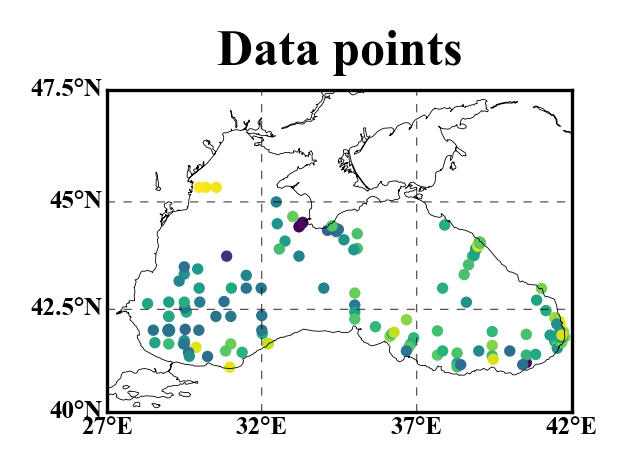

In [12]:
fig = plt.figure(figsize=(2, 2))
Data.add_to_plot(m=m, s=3)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2)
plt.title('Data points')
plt.show()
plt.close()

## Contours

DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding contours to map
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


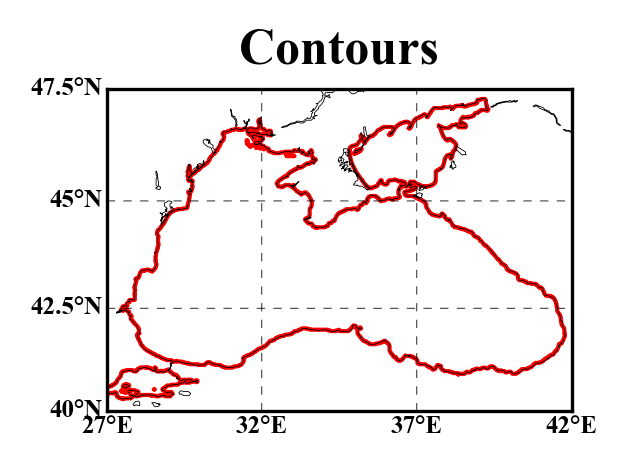

In [13]:
fig = plt.figure(figsize=(2, 2))
Contour.add_to_plot(m=m, linewidth=2, color='.75')
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Contours')
plt.show()
plt.close()

## Finite element mesh

We create an object that stores the mesh characteristics and coordinates:

In [14]:
Mesh = pydiva2d.Diva2DMesh(DivaFiles.mesh, DivaFiles.meshtopo)

INFO:diva2D:Creating Diva 2D mesh object


To create the plot, we add the option *m* in the **add_to_plot** function.

DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding finite-element mesh to map
DEBUG:diva2D:Setting limits to axes


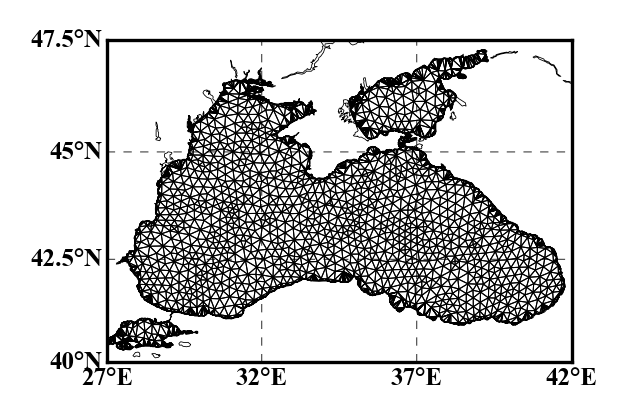

In [15]:
fig = plt.figure(figsize=(2, 2))
ax = plt.subplot(111)
Mesh.add_to_plot(ax, m, linewidth=0.25)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)

## Analysed field

We follow the same approach as with the finite element mesh: first create the object, then add it to the map.

In [16]:
reload(pydiva2d)
Mesh = pydiva2d.Diva2DMesh(DivaFiles.mesh, DivaFiles.meshtopo)
Analysis = pydiva2d.Diva2DResults(DivaFiles.result)

INFO:diva2D:Creating Diva 2D mesh object


DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding analysed field to plot
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)


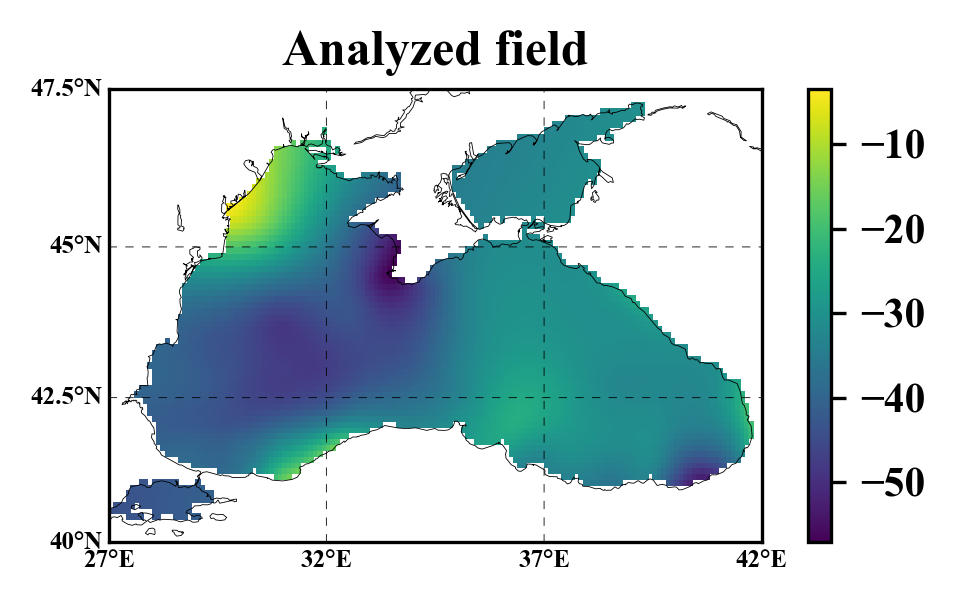

In [17]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(111)
Analysis.add_to_plot(ax=ax, m=m)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Analyzed field')

## Data, contour, mesh and analysis

Finally we can easily combine every element on the same the map.

In [18]:
fig = plt.figure(figsize=(4, 2))
ax = plt.subplot(111)
Analysis.add_to_plot(ax=ax, m=m, vmin=-60, vmax=-5)
Mesh.add_to_plot(ax=ax, m=m, alpha=0.2, linewidth=0.25)
Contour.add_to_plot(m=m, linewidth=1, color='0.75')
Data.add_to_plot(m=m, s=3, vmin=-60, vmax=-5)
m.drawmeridians(np.linspace(Param.xori, Param.xend, 4), labels=[0, 0, 0, 1], linewidth=0.2, fontsize=6)
m.drawparallels(np.linspace(Param.yori, Param.yend, 4), labels=[1, 0, 0, 0], linewidth=0.2, fontsize=6)
m.drawcoastlines(linewidth=0.2, zorder=3)
plt.title('Analyzed field, mesh, contour and data')
plt.savefig('./BlackSea_AnalysisMeshData2.png', dpi=300)
plt.close()

DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding analysed field to plot
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3413: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3422: MatplotlibDeprecationWarning: axes.hold is deprecated.
    See the API Changes document (http://matplotlib.org/api/api_changes.html)
    for more details.
  ax.hold(b)
DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding finite-element mesh to map
DEBUG:diva2D:Setting limits to axes
DEBUG:diva2D:Applying projection to coordinates
DEBUG:diva2D:Adding contours to map
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3260: MatplotlibDeprecationWarning: The ishold function was deprecated in version 2.0.
  b = ax.ishold()
/usr/local/lib/python3.6/site-packages/mpl_toolkits/basemap/__init__.py:3269: MatplotlibDeprec